# Control with collision avoidance


We have $n$ linear dynamic systems, given by

$$
x^i_{t+1} = A^i x^i_t + B^i u^i_t, 
\qquad 
y^i_t = C^i x^i_t, 
\qquad i = 1, \ldots, n,
$$

where $t = 0, 1, \ldots$ denotes (discrete) time, $x^i_t$ are the states, and $y^i_t$ 
are the outputs. At each time $t$ for $t = 0, \ldots, T$ the $n$ outputs $y^i_t$ are 
required to keep a distance of at least $d_{\min}$ from each other.  

The initial states $x^i_0$ and ending states $x^i_T$ are given by $x^i_{\text{init}}$ 
and $x^i_{\text{end}}$, and the inputs are limited by 

$$
\|u^i_t\|_\infty \leq f_{\max}.
$$  

We will cp.Minimize a sum of the $\ell_1$ norms of the inputs, an approximation of fuel 
use. (Of course we can have any convex state and input constraints, and any convex 
objective.) This gives the cp.Problem

$$
\begin{array}{ll}
\text{cp.Minimize}   & \displaystyle \sum_{i=1}^n \sum_{t=0}^{T-1} \|u^i_t\|_1 \\
\text{subject to} 
& x^i_0 = x^i_{\text{init}}, \quad x^i_T = x^i_{\text{end}}, \quad i = 1, \ldots, n, \\
& x^i_{t+1} = A^i x^i_t + B^i u^i_t, \quad t = 0, \ldots, T-1, \; i = 1, \ldots, n, \\
& \|y^i_t - y^j_t\|_2 \geq d_{\min}, \quad t = 0, \ldots, T, \; 1 \leq i < j \leq n, \\
& y^i_t = C^i x^i_t, \quad \|u^i_t\|_\infty \leq f_{\max}, \quad t = 0, \ldots, T-1, \; i = 1, \ldots, n,
\end{array}
$$

where $x^i_t$, $y^i_t$, and $u^i_t$ are cp.Variables.


## Example

We consider an instance with $n = 2$, with outputs (positions) $y^i_t \in \mathbb{R}^2$, 
$d_{\min} = 0.6$, $f_{\max} = 0.5$, $T = 100$.  
The linear dynamic system matrices are

$$
A^i =
\begin{bmatrix}
1 & 0 & 0.1 & 0 \\
0 & 1 & 0 & 0.1 \\
0 & 0 & 0.95 & 0 \\
0 & 0 & 0 & 0.95
\end{bmatrix}, 
\quad
B^i =
\begin{bmatrix}
0 & 0 \\
0 & 0 \\
0.1 & 0 \\
0 & 0.1
\end{bmatrix}, 
\quad
C^i =
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{bmatrix}.
$$

The results are in Figure~4, where the black arrows in the first two figures show initial and 
final states (position and velocity), and the black dashed line in the third figure shows $d_{\min}$.


## With collision avoidance

In [ ]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

from dccp import is_dccp

T = 100
l = 6.0
m = 1
v_max = 0.15
d_min = 0.6
A = np.matrix([[1, 0, 0.1, 0], [0, 1, 0, 0.1], [0, 0, 0.95, 0], [0, 0, 0, 0.95]])
B = np.matrix([[0, 0], [0, 0], [0.1 / float(m), 0], [0, 0.1 / float(m)]])
C = np.matrix([[1, 0, 0, 0], [0, 1, 0, 0]])
d = 2  # dim of space
n = 2  # number of systems
x_ini = np.array([[1, 4, 0.5, 0.5], [3, 5, -0.5, 0]])
x_end = np.array([[3, 3, 0, -0.5], [3.5, 3.5, 0.5, -0.5]])
f_max = 0.5

u = []
y = []
x = []
for i in range(n):
    u.append([])
    y.append([])
    x.append([])
cost = 0
constr = []

for i in range(n):
    for t in range(T):
        u[i] += [cp.Variable(d)]
        constr += [cp.norm(u[i][-1], "inf") <= f_max]
        cost += cp.pnorm(u[i][-1], 1)
        y[i] += [cp.Variable(d)]
        x[i] += [cp.Variable(2 * d)]
        constr += [y[i][-1] == C @ x[i][-1]]
    constr += [x[i][0] == x_ini[i]]
    constr += [x[i][-1] == x_end[i]]

for i in range(n):
    for t in range(T - 1):
        constr += [x[i][t + 1] == A @ x[i][t] + B @ u[i][t]]

for t in range(T):
    for i in range(n - 1):
        for j in range(i + 1, n):
            constr += [cp.norm(y[i][t] - y[j][t]) >= d_min]

# solve the problem
prob = cp.Problem(cp.Minimize(cost), constr)
assert is_dccp(prob), "Problem is not DCCP"
prob.solve(method="dccp", ep=1e-1)

45.14747053787909

## Without collision avoidance

In [3]:
u_c = []
y_c = []
x_c = []
for i in range(n):
    u_c.append([])
    y_c.append([])
    x_c.append([])
cost_c = 0
constr_c = []
for i in range(n):
    for t in range(T):
        u_c[i] += [cp.Variable(d)]
        constr += [cp.pnorm(u_c[i][-1], "inf") <= f_max]
        cost_c += cp.pnorm(u_c[i][-1], 1)
        y_c[i] += [cp.Variable(d)]
        x_c[i] += [cp.Variable(2 * d)]
        constr_c += [y_c[i][-1] == C @ x_c[i][-1]]
    constr_c += [x_c[i][0] == x_ini[i]]
    constr_c += [x_c[i][-1] == x_end[i]]
for i in range(n):
    for t in range(T - 1):
        constr_c += [x_c[i][t + 1] == A @ x_c[i][t] + B @ u_c[i][t]]
prob_c = cp.Problem(cp.Minimize(cost_c), constr_c)
prob_c.solve()

np.float64(45.12876784377806)

## Visualization of the optimal trajectories

In [37]:
# Helper functions for plotting
def extract_trajectory(y_vars, system_idx):
    """Extract x and y coordinates from trajectory variables."""
    x_coords = [xx.value[0] for xx in y_vars[system_idx]]
    y_coords = [xx.value[1] for xx in y_vars[system_idx]]
    return x_coords, y_coords

def plot_arrows(x_initial, x_final):
    """Plot initial and final state arrows for all systems."""
    for i in range(len(x_initial)):
        # initial state
        plt.quiver(
            x_initial[i][0], x_initial[i][1], x_initial[i][2], x_initial[i][3],
            units="xy", scale=2, zorder=3, color="black",
            width=0.01, headwidth=4.0, headlength=5.0
        )
        # final state
        plt.quiver(
            x_final[i][0], x_final[i][1], x_final[i][2], x_final[i][3],
            units="xy", scale=2, zorder=3, color="black",
            width=0.01, headwidth=4.0, headlength=5.0
        )

def setup_trajectory_plot(title):
    """Setup trajectory plots."""
    plt.xlim(0.5, 4.5)
    plt.ylim(2, 6)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(title, fontsize=18)
    plt.xlabel("X Position", fontsize=16)
    plt.ylabel("Y Position", fontsize=16)
    plt.tick_params(axis="both", which="major", labelsize=14)

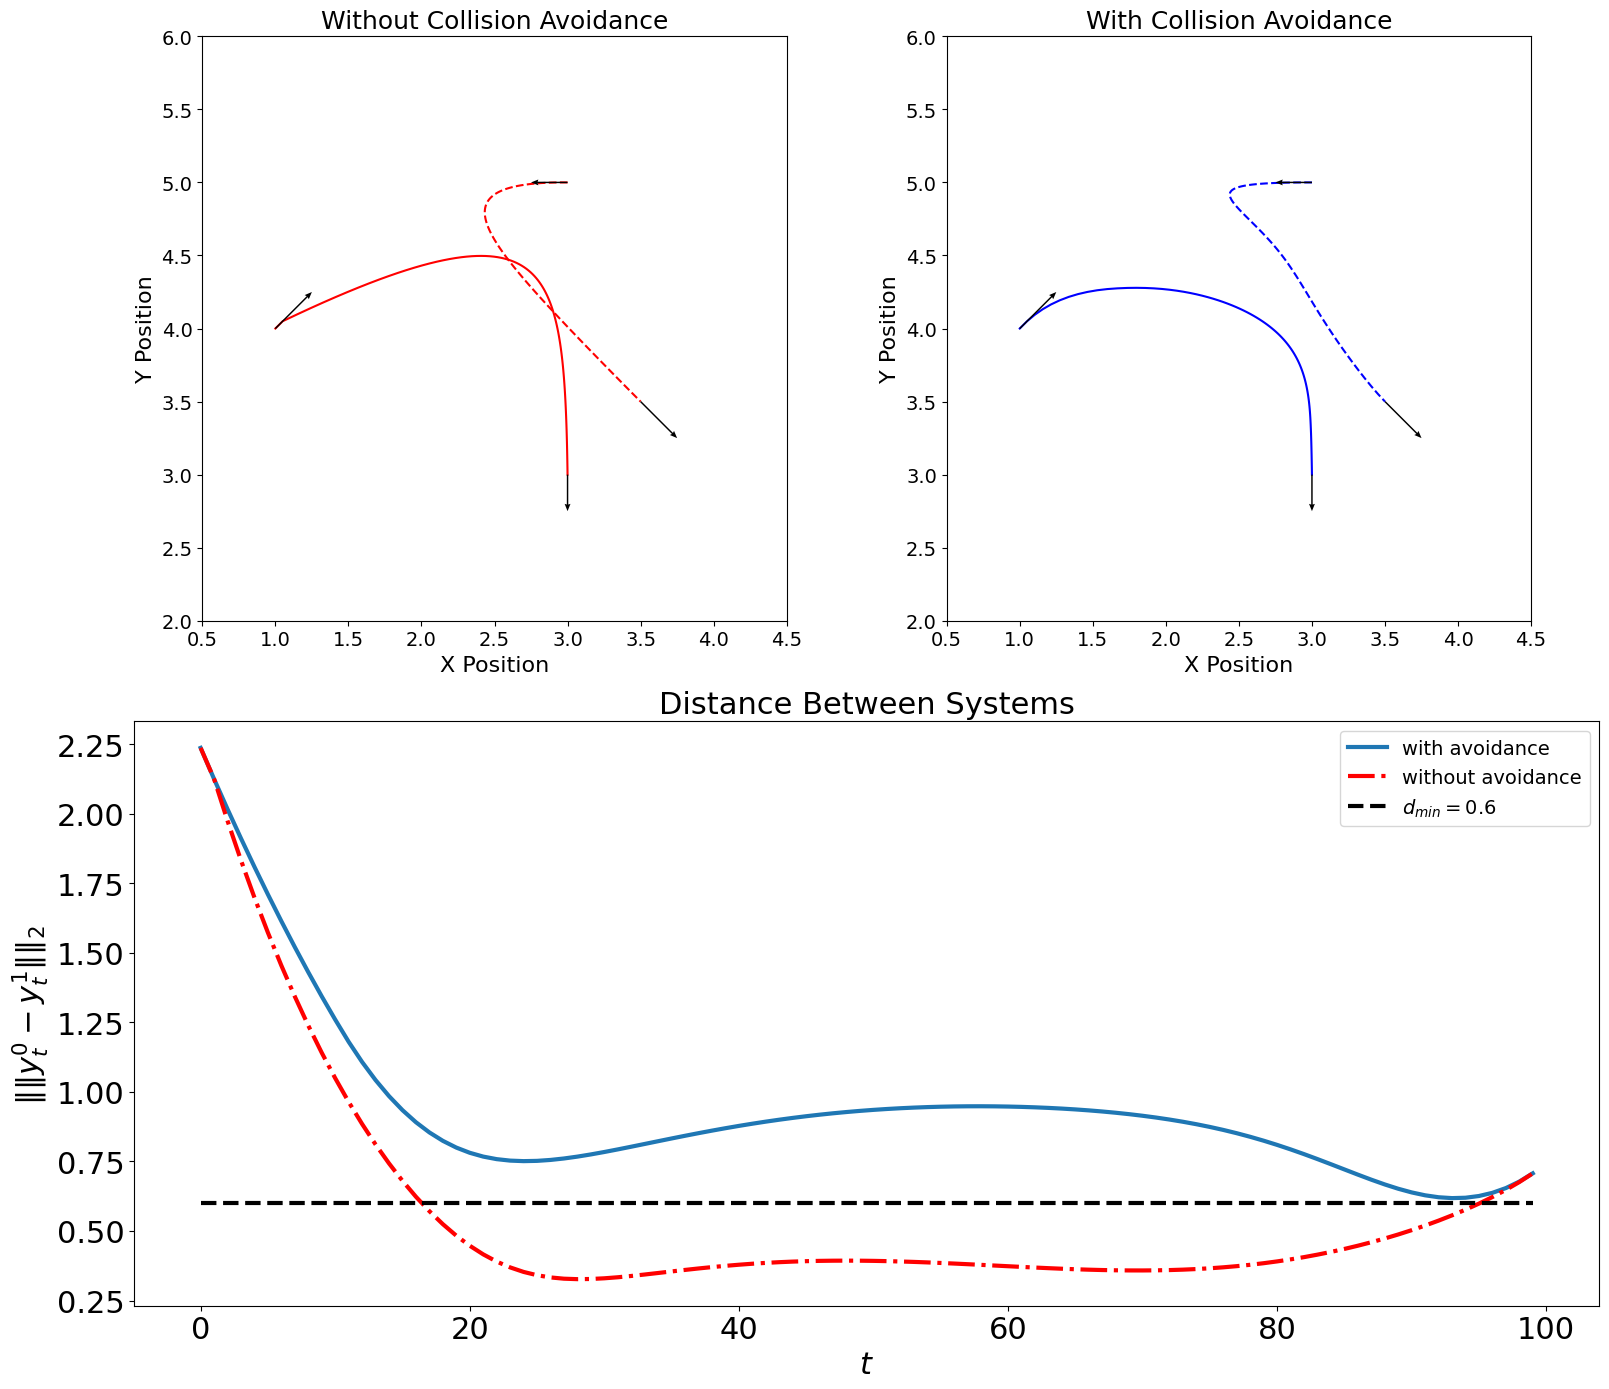

In [44]:
plt.figure(figsize=(16, 14))

# Top left subplot: Without collision avoidance
plt.subplot(2, 2, 1)
ax, ay = extract_trajectory(y_c, 0)
bx, by = extract_trajectory(y_c, 1)
plt.plot(ax, ay, "r", label="System 1")
plt.plot(bx, by, "r--", label="System 2")
plot_arrows(x_ini, x_end)
setup_trajectory_plot("Without Collision Avoidance")

# Top right subplot: With collision avoidance
plt.subplot(2, 2, 2)
ax, ay = extract_trajectory(y, 0)
bx, by = extract_trajectory(y, 1)
plt.plot(ax, ay, "b-", label="System 1")
plt.plot(bx, by, "b--", label="System 2")
plot_arrows(x_ini, x_end)
setup_trajectory_plot("With Collision Avoidance")

# Bottom subplot spanning both columns: Distance comparison
plt.subplot(2, 1, 2)
distance = [cp.pnorm(y[0][t] - y[1][t], 2).value for t in range(T)]
distance_c = [cp.pnorm(y_c[0][t] - y_c[1][t], 2).value for t in range(T)]

plt.plot(range(T), distance, label="with avoidance", linewidth=3)
plt.plot(range(T), distance_c, "r-.", label="without avoidance", linewidth=3)
plt.plot(
    range(T),
    d_min * np.ones((T, 1)),
    "k--",
    label=f"$d_{{min}} = {d_min}$",
    linewidth=3,
)
plt.legend(loc=0, fontsize=14)
plt.ylabel(r"$\|\|y^0_t - y^1_t\|\|_2$", fontsize=22)
plt.xlabel("$t$", fontsize=22)
plt.title("Distance Between Systems", fontsize=22)
plt.tick_params(axis="both", which="major", labelsize=22)

plt.tight_layout()
plt.show()